<a href="https://colab.research.google.com/github/djonpietro/AP-MAQ-UFRJ/blob/main/projeto2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Aprendizagem de Máquina I

## Hugo Tremonte de Carvalho

#### hugo@dme.ufrj.br

* NOME: João Pedro Silva de Sousa
* DRE: 122122366
* E-MAIL CADASTRADO NO CLASSROOM: joaopss@dcc.ufrj.br

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from skimage.restoration import estimate_sigma
from skimage.exposure import rescale_intensity, equalize_adapthist
from skimage.filters import gaussian, sobel

from sklearn.decomposition import PCA

In [ ]:
# Utils

PIXELS = 30
N_FEATURES = PIXELS ** 2
cols = list(range(N_FEATURES))

# plotar a distribuição do ruído
def plot_sigmas(sigmas, ax=None):
    """
    Plottar distribuição do ruído
    """
    print(sigmas.describe())
    xmin, xmax = sigmas.min(), sigmas.max()
    x = np.linspace(xmin, xmax, 100)
    y = stats.norm.pdf(x, sigmas.mean(), sigmas.std())
    # plt.hist(sigmas, density=True, bins=30, alpha=0.6)
    sns.histplot(sigmas, alpha=0.6, kde=True, bins=30, ax=ax, stat='density')
    ax.plot(x, y, c='orange', label='densidade da normal ajustada')
    plt.legend()

# Devolve o sigma estimado
def sigma(img: np.array):
    """
    Estimar o ruído
    """
    return estimate_sigma(img, average_sigmas=True)

def apply_processor(df: pd.DataFrame, processor, **kwargs):
    """
    Função para aplicar uma transformação no dataset
    """
    processed = [processor(img, **kwargs).flat for img in get_image_gen(df)]
    return pd.DataFrame(processed)

def resize(df: pd.DataFrame, pixels: int):
    """
    Função para realizar redimensionamento do dataset
    craindo uma imagem pixelsxpixels concentrica com
    a original
    """
    values = []
    shape = int(np.sqrt(len(df.columns)))
    shape_half = shape // 2
    low = shape_half - pixels // 2
    high = shape_half + pixels // 2
    for idx in range(df.shape[0]):
        d = df.iloc[idx].values.reshape(shape, shape)[low:high, low:high]
        values.append(d.flat)
    return pd.DataFrame(values)

# Função Geradora para iterar nas imagens
def get_image_gen(df: pd.DataFrame):
    """
    Função geradora para iterar sobre as imagens
    """
    shape = int(np.sqrt(len(df.columns)))
    for i in range(df.shape[0]):
        yield np.array(df.iloc[i]).reshape((shape, shape))

def print_image(df: pd.DataFrame, resp: pd.DataFrame, idx: int,/, title='', shape:tuple=(PIXELS,PIXELS)):
    """
    Rotina para imprimir mostrar uma determinada imagem
    """
    print(resp.iloc[idx])
    image = np.array(df.iloc[idx]).reshape(shape)
    plt.figure()
    plt.imshow(image,cmap="gray")
    plt.title(title)
    plt.show()


def img_nomalize(img: np.array):
    """
    Padroniza uma imagem
    """
    return (img - img.mean()) / (img.std() + 1e-8)

def feat_normalize(df: pd.DataFrame):
    """
    Padroniza todas as imagens no dataset
    """
    return df.apply(img_nomalize, axis=1)


def pre_process(df: pd.DataFrame):
    """
    Pipeline usada para aplicar todas as transformações
    de interesse no dataset
    """
    data = resize(df, PIXELS)
    data = apply_processor(data, gaussian, sigma=0.8)
    data = apply_processor(apply_processor(data, rescale_intensity, out_range=(0,1)), equalize_adapthist, clip_limit = 0.03)
    data = feat_normalize(data)
    return data

In [ ]:
feat = pd.read_csv('data/train_images.csv', header = None) # 'header = None' é importante pois o .csv não tem cabeçalho.
                                                      # Sem 'header = None' a primeira imagem será lida como o nome das colunas do dataframe.
resp = pd.read_csv('data/train_labels.csv')

In [ ]:
feat_test = pd.read_csv('data/test_images.csv', header = None) # Utilizar 'header = None' pelo mesmo motivo acima.
resp_test = pd.read_csv('data/test_labels.csv')

In [ ]:
feat_rezised = resize(feat, PIXELS)

# Pré-Processamento do Dataset

Iremos Tentar realizar um pré-processamento das imagens, como foi aconselhado. O primeiro
passo será remover ruído nos pixel das imagens, o que pode ser comum para imagens planetárias

In [ ]:
# Cria um array com os ruídos em cada imagem
sigmas = [sigma(img) if img.std() > 1e-6 else np.nan for img in get_image_gen(feat_rezised) ]

             sigma
count  1000.000000
mean      4.835094
std       1.181411
min       0.552649
25%       4.492312
50%       5.115274
75%       5.568830
max       7.884521


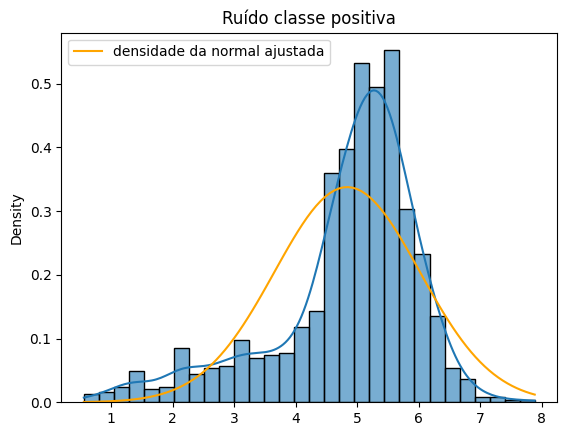

In [ ]:
sigmas = pd.DataFrame(sigmas, columns=['sigma'])
ax = plt.subplot()
plt.title('Ruído classe positiva')
plot_sigmas(sigmas[resp['Volcano?'] == 1], ax)
plt.show()

             sigma
count  5841.000000
mean      5.128912
std       1.066458
min       1.810248
25%       4.734644
50%       5.256050
75%       5.669467
max      16.957502


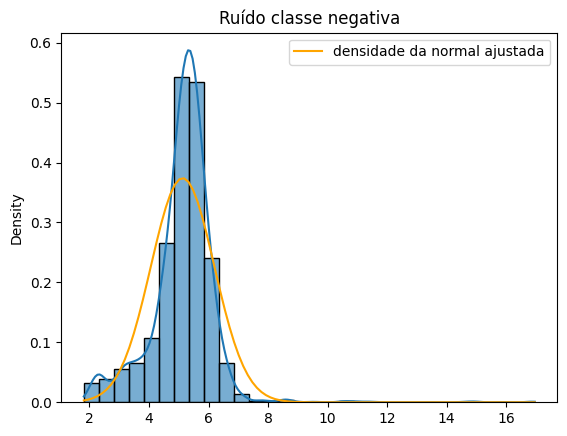

In [ ]:
ax = plt.subplot()
plt.title('Ruído classe negativa')
plot_sigmas(sigmas[resp['Volcano?'] == 0], ax)

Os ruídos nas duas classes possuem distribuições mais afuniladas do que uma normal,
apesar de terem comportamento parecido. Essas distribuições também se assemelham em
suas médias, desvio e quartis, porém o ruído da classe negativa tem uma aplitude maior
de valores. Por mais que o comportamento do ruído não seja de fato normal, iremos
aplicar um filtro gaussiano leve para limpar um pouco as imagens

In [ ]:
feat_rezised = apply_processor(feat_rezised, gaussian,sigma=0.8)

Volcano?             1.00
Type                 1.00
Radius              22.02
Number Volcanoes     1.00
Name: 9, dtype: float64


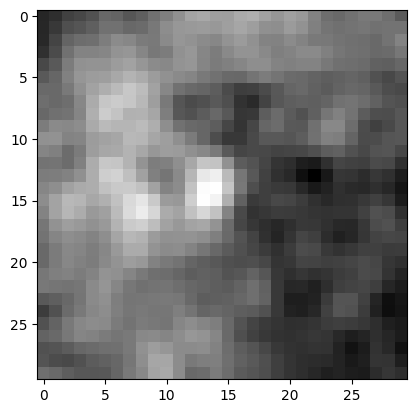

In [ ]:
print_image(feat_rezised, resp, 9)

Volcano?            0.0
Type                NaN
Radius              NaN
Number Volcanoes    NaN
Name: 1, dtype: float64


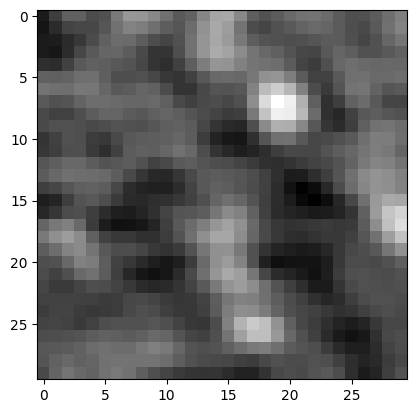

In [ ]:
print_image(feat_rezised, resp, 1)

Volcano?            1.00
Type                3.00
Radius              5.83
Number Volcanoes    5.00
Name: 853, dtype: float64


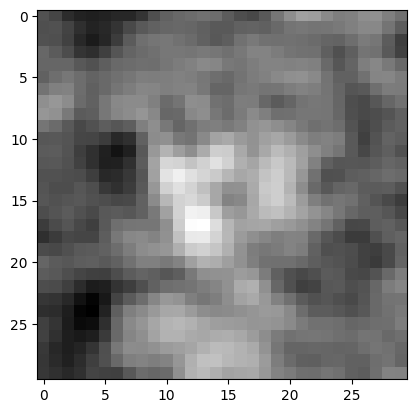

In [ ]:
print_image(feat_rezised, resp, 853)

As imagens que possuem vulcões geralmente possuem o centro mais claro. Provavelmente,
são essas features que estamos buscando, então seria adequando que conseguísemos ajustar o
contraste da imagem de modo a realçar as áreas brancas, enquanto que as escuras ficassem
mais escuras. Com algumas pesquisas, pude ver que o skimage implementa o algoritmo
CLAHE, que realiza a tarefa desejada.

In [ ]:
feat_rezised = apply_processor(apply_processor(feat_rezised, rescale_intensity, out_range=(0,1)), equalize_adapthist, clip_limit = 0.03)

Volcano?             1.00
Type                 1.00
Radius              22.02
Number Volcanoes     1.00
Name: 9, dtype: float64


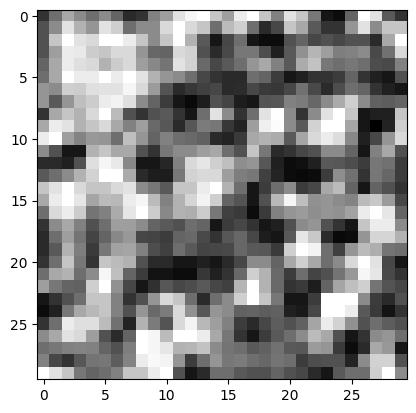

In [ ]:
print_image(feat_rezised, resp, 9)

Volcano?             1.00
Type                 3.00
Radius              17.46
Number Volcanoes     1.00
Name: 0, dtype: float64


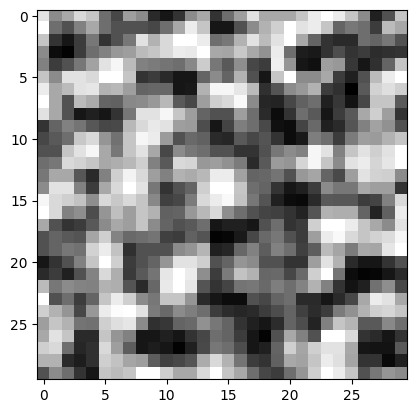

In [ ]:
print_image(feat_rezised, resp, 0)

Volcano?            0.0
Type                NaN
Radius              NaN
Number Volcanoes    NaN
Name: 2004, dtype: float64


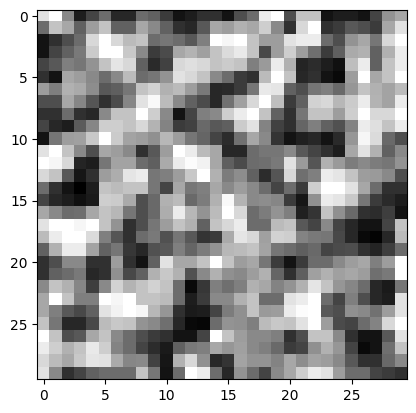

In [ ]:
print_image(feat_rezised, resp, 2004)

A vizualização humana foi dificultada por esse filtro, então vamos tentar ver
dividido por classes

Text(0.5, 1.0, 'Distribuição médias pós equalização (positivo)')

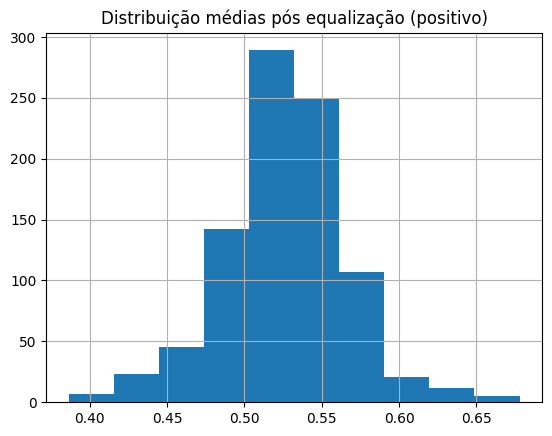

In [ ]:
feat_rezised[resp['Volcano?'] == 1].describe().loc['mean'].hist()
plt.title('Distribuição médias pós equalização (positivo)')

Text(0.5, 1.0, 'Distribuição médias pós equalização (negativo)')

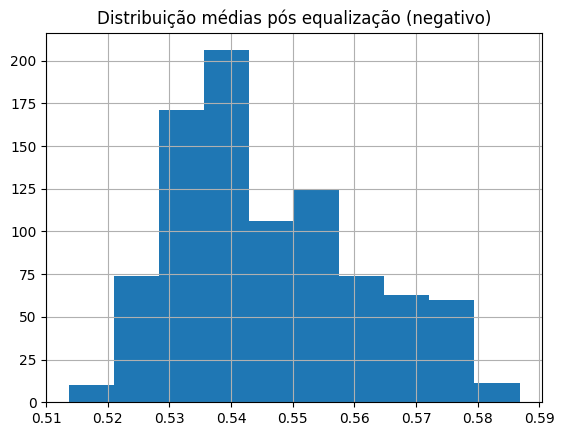

In [ ]:
feat_rezised[resp['Volcano?'] == 0].describe().loc['mean'].hist()
plt.title('Distribuição médias pós equalização (negativo)')

Na nossa amostra, vamos que a distribuição das médias dos valores dos
pixels dada a classe são distintos. Na classe positiva, temos uma distribuição
muito próxima de uma normal. Já na classe negativa, a distribuição é um pouco
assimétrica para a esquerda, e possui caudas mais pesadas. Logo, podemos
hipotetizar que após a aplicação do filtro obtemos que a distribuição dos valores
dos pixels dada a classe se tornaram distintas, o que é bom para nosso
objetivo de classificação

Por fim, iremos padronizar as imagens para que os pixels tenha média
zero e variância 1. Não há vazamentos de dados aqui, pois o processo
é feito por observação, e não por feature.

In [ ]:
feat_rezised = feat_normalize(feat_rezised)

# Aplicação de Redução de Dimensionalidade

Na seção anterior, aplicamos algumas transformações nas imagens que simplificaram
bastante as suas informaçẽos. Seguindo a recomendação, iremos aplicar o PCA para
reduzir o número de features atuais.

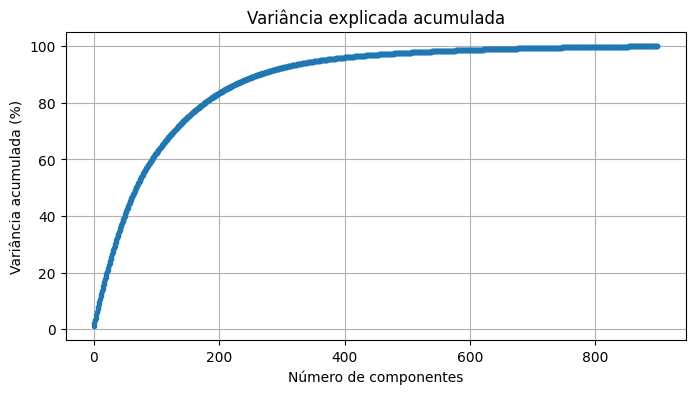

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA()
feat_pca = pca.fit_transform(StandardScaler().fit_transform(feat_rezised))

explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(explained_variance)*100, marker='.')
plt.xlabel("Número de componentes")
plt.ylabel("Variância acumulada (%)")
plt.title("Variância explicada acumulada")
plt.grid(True)
plt.show()

Do gráfico, podemos concluir que com as primeiras 200 componentes
principais já conseguimos explicar 80% da variância dos dados, de forma
a eliminar 11900 features do dataset original, dado o recorte 30x30,
e 700 do recorte sendo usado.

In [ ]:
from sklearn.preprocessing import StandardScaler
pca_red = PCA(n_components=200)
feat_pca = pca_red.fit_transform(StandardScaler().fit_transform(feat_rezised))

/tmp/ipykernel_6285/2110607854.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.title(f'vulc = {resp.iloc[idx][0]}')


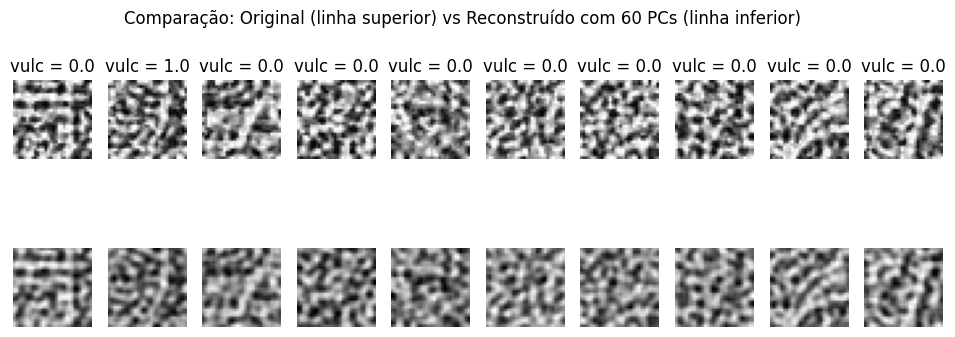

In [ ]:
inverse = pca_red.inverse_transform(feat_pca)
plt.figure(figsize=(12, 4))
for i, idx in enumerate(np.random.choice(len(feat), 10, replace=False)):
    # Original
    plt.subplot(2, 10, i + 1)
    plt.imshow(np.array(feat_rezised.iloc[idx]).reshape(PIXELS, PIXELS), cmap='gray')
    plt.title(f'vulc = {resp.iloc[idx][0]}')
    plt.axis('off')
    # Reconstruído
    plt.subplot(2, 10, i + 11)
    # plt.imshow(np.array(feat_norm.iloc[idx]).reshape(PIXELS, PIXELS), cmap='gray')
    plt.imshow(inverse[idx].reshape(PIXELS, PIXELS), cmap='gray')
    plt.axis('off')
plt.suptitle(f"Comparação: Original (linha superior) vs Reconstruído com {60} PCs (linha inferior)")
plt.show()


Pela reconstrução feita, podemos observar que as componentes pelo
menos aparentam capturar bem a variância, além de simplificar também as imagens

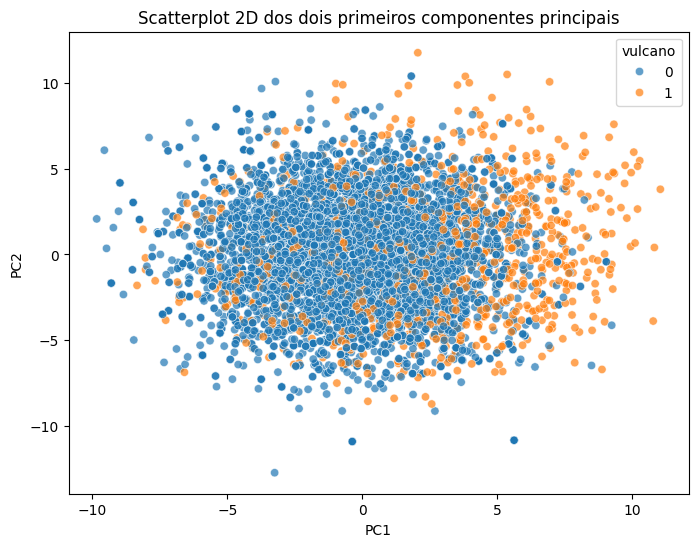

In [ ]:
df_2d = pd.DataFrame(feat_pca[:, :2], columns=['PC1', 'PC2'])
df_2d['vulcano'] = resp['Volcano?']

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_2d, x='PC1', y='PC2', hue='vulcano', palette='tab10', legend='full', alpha=0.7)
plt.title("Scatterplot 2D dos dois primeiros componentes principais")
plt.show()


Pela vizualização com apenas 2 componentes, vemos que as classes estão sobrepostos,
o que não é de todo mal, já que duas componentes não capturam nem 10% da variação total

In [ ]:
import plotly.express as px

df_3d = pd.DataFrame(feat_pca[:, :3], columns=['PC1', 'PC2', 'PC3'])
df_3d['vulcano'] = resp['Volcano?']

fig = px.scatter_3d(
    df_3d,
    x='PC1', y='PC2', z='PC3',
    color='vulcano',
    color_discrete_sequence=px.colors.qualitative.Set1,
    title="Scatterplot 3D dos três primeiros componentes principais",
    width=800, height=600
)

fig.update_traces(marker=dict(size=2, opacity=0.7))
fig.show()

Aqui a sobreposiçã dos dados ainda se mantém. O interessante é também
ver que em dimensão 3 os dados parecem formar uma esfera.

In [ ]:
df = pd.DataFrame(feat_pca)
df['y'] = resp['Volcano?']

df_1 = df[df['y'] == 1].drop(columns=['y'])

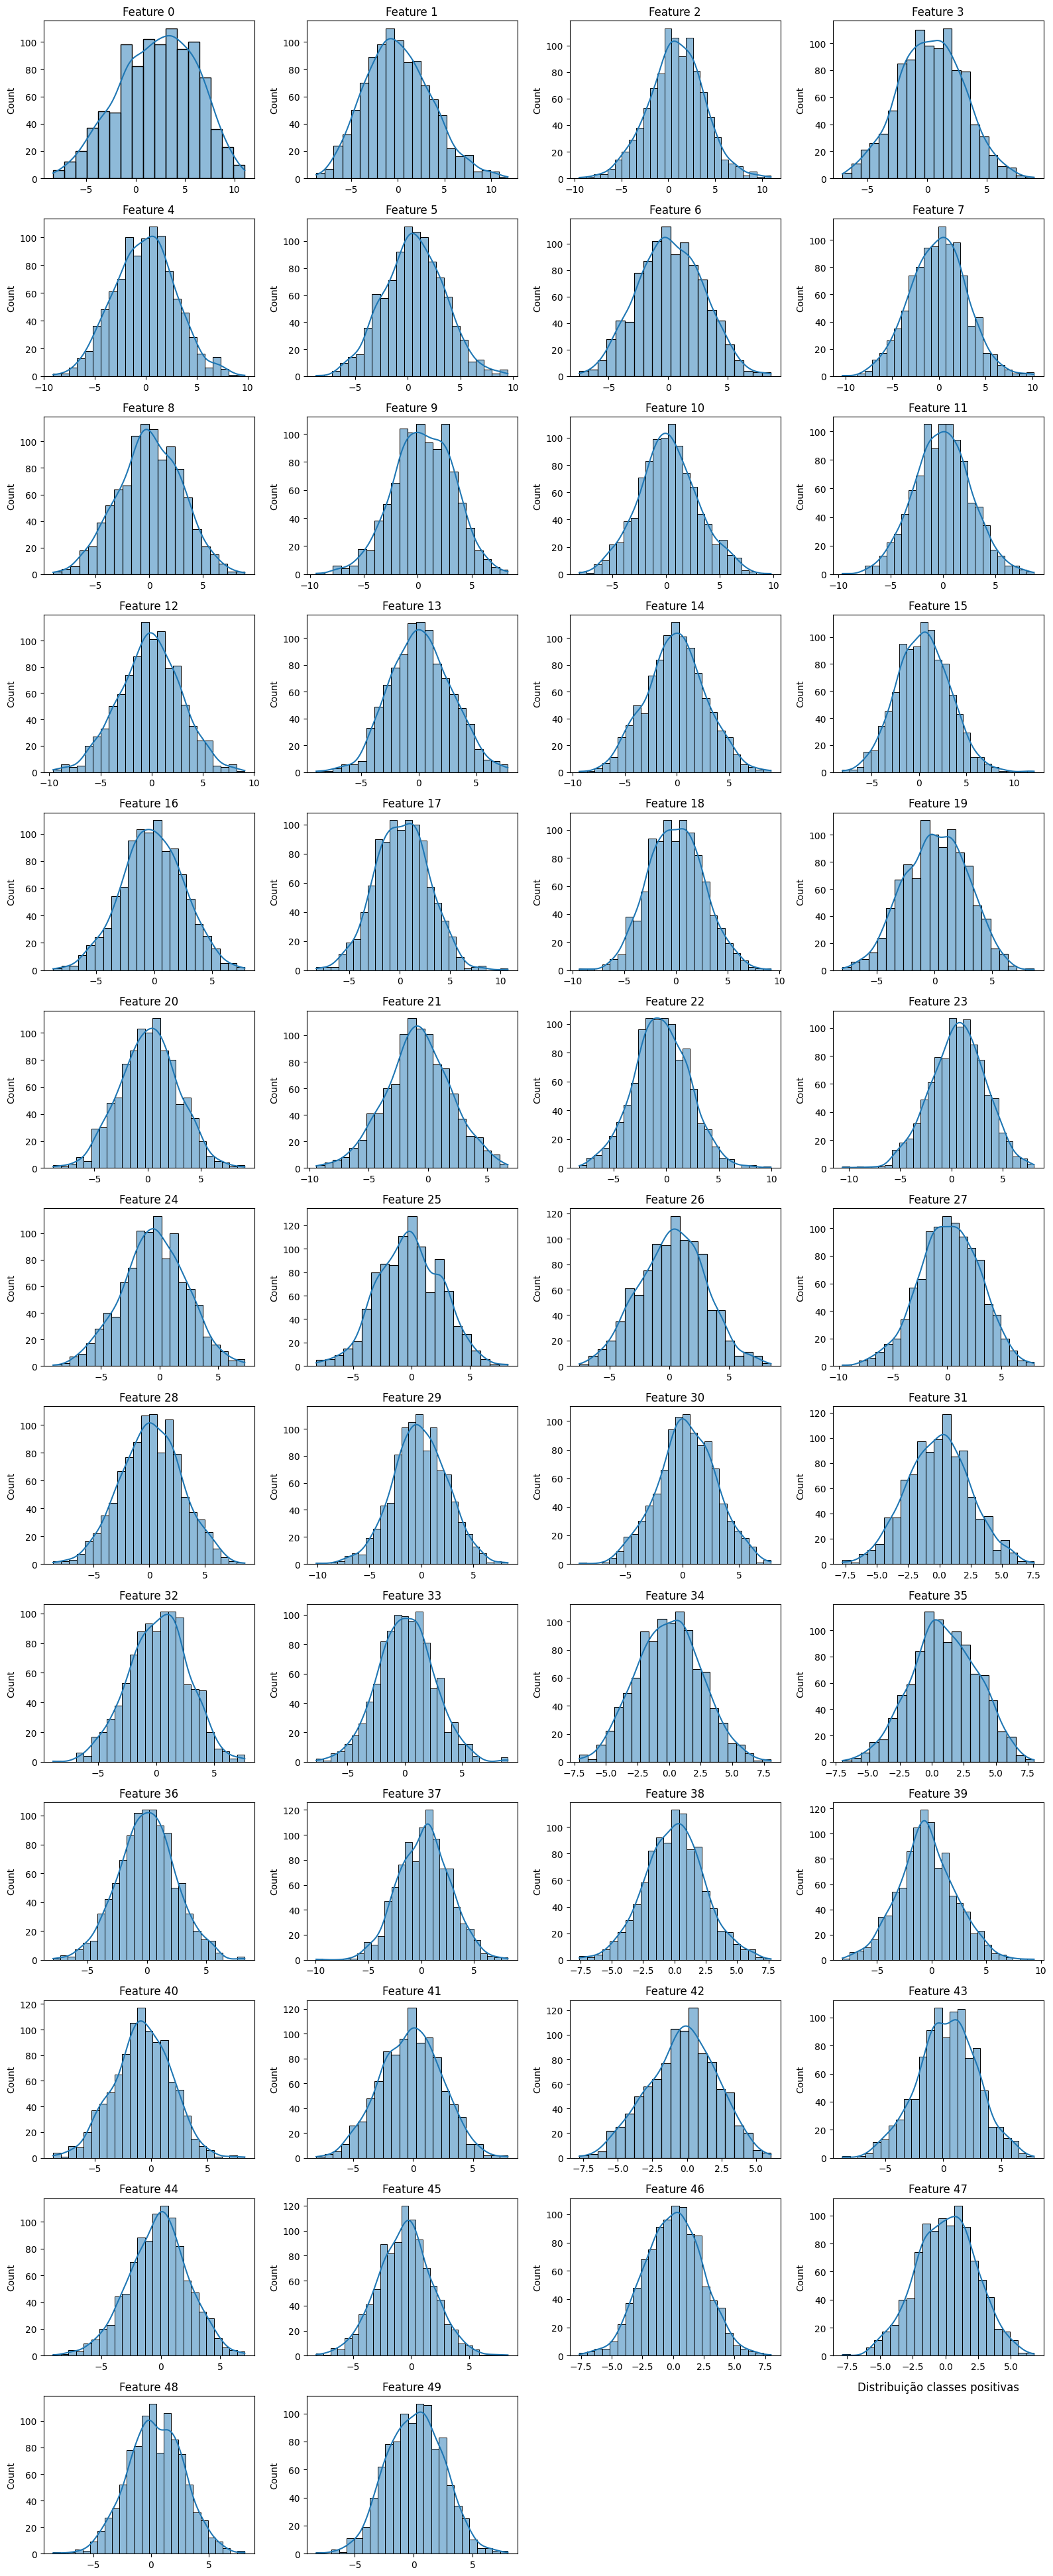

In [ ]:
def show_features_hist(data: np.array, title: str):
    n_features = data.shape[1]
    cols = 4                       # número de colunas no grid
    rows = (n_features + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
    axes = axes.flatten()

    for i in range(n_features):
        sns.histplot(data[:, i], kde=True, ax=axes[i])
        axes[i].set_title(f"Feature {i}")

    # remove eixos vazios
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.title(title)
    plt.tight_layout()
    plt.show()

show_features_hist(np.array(df_1[cols[:50]]), title='Distribuição classes positivas')

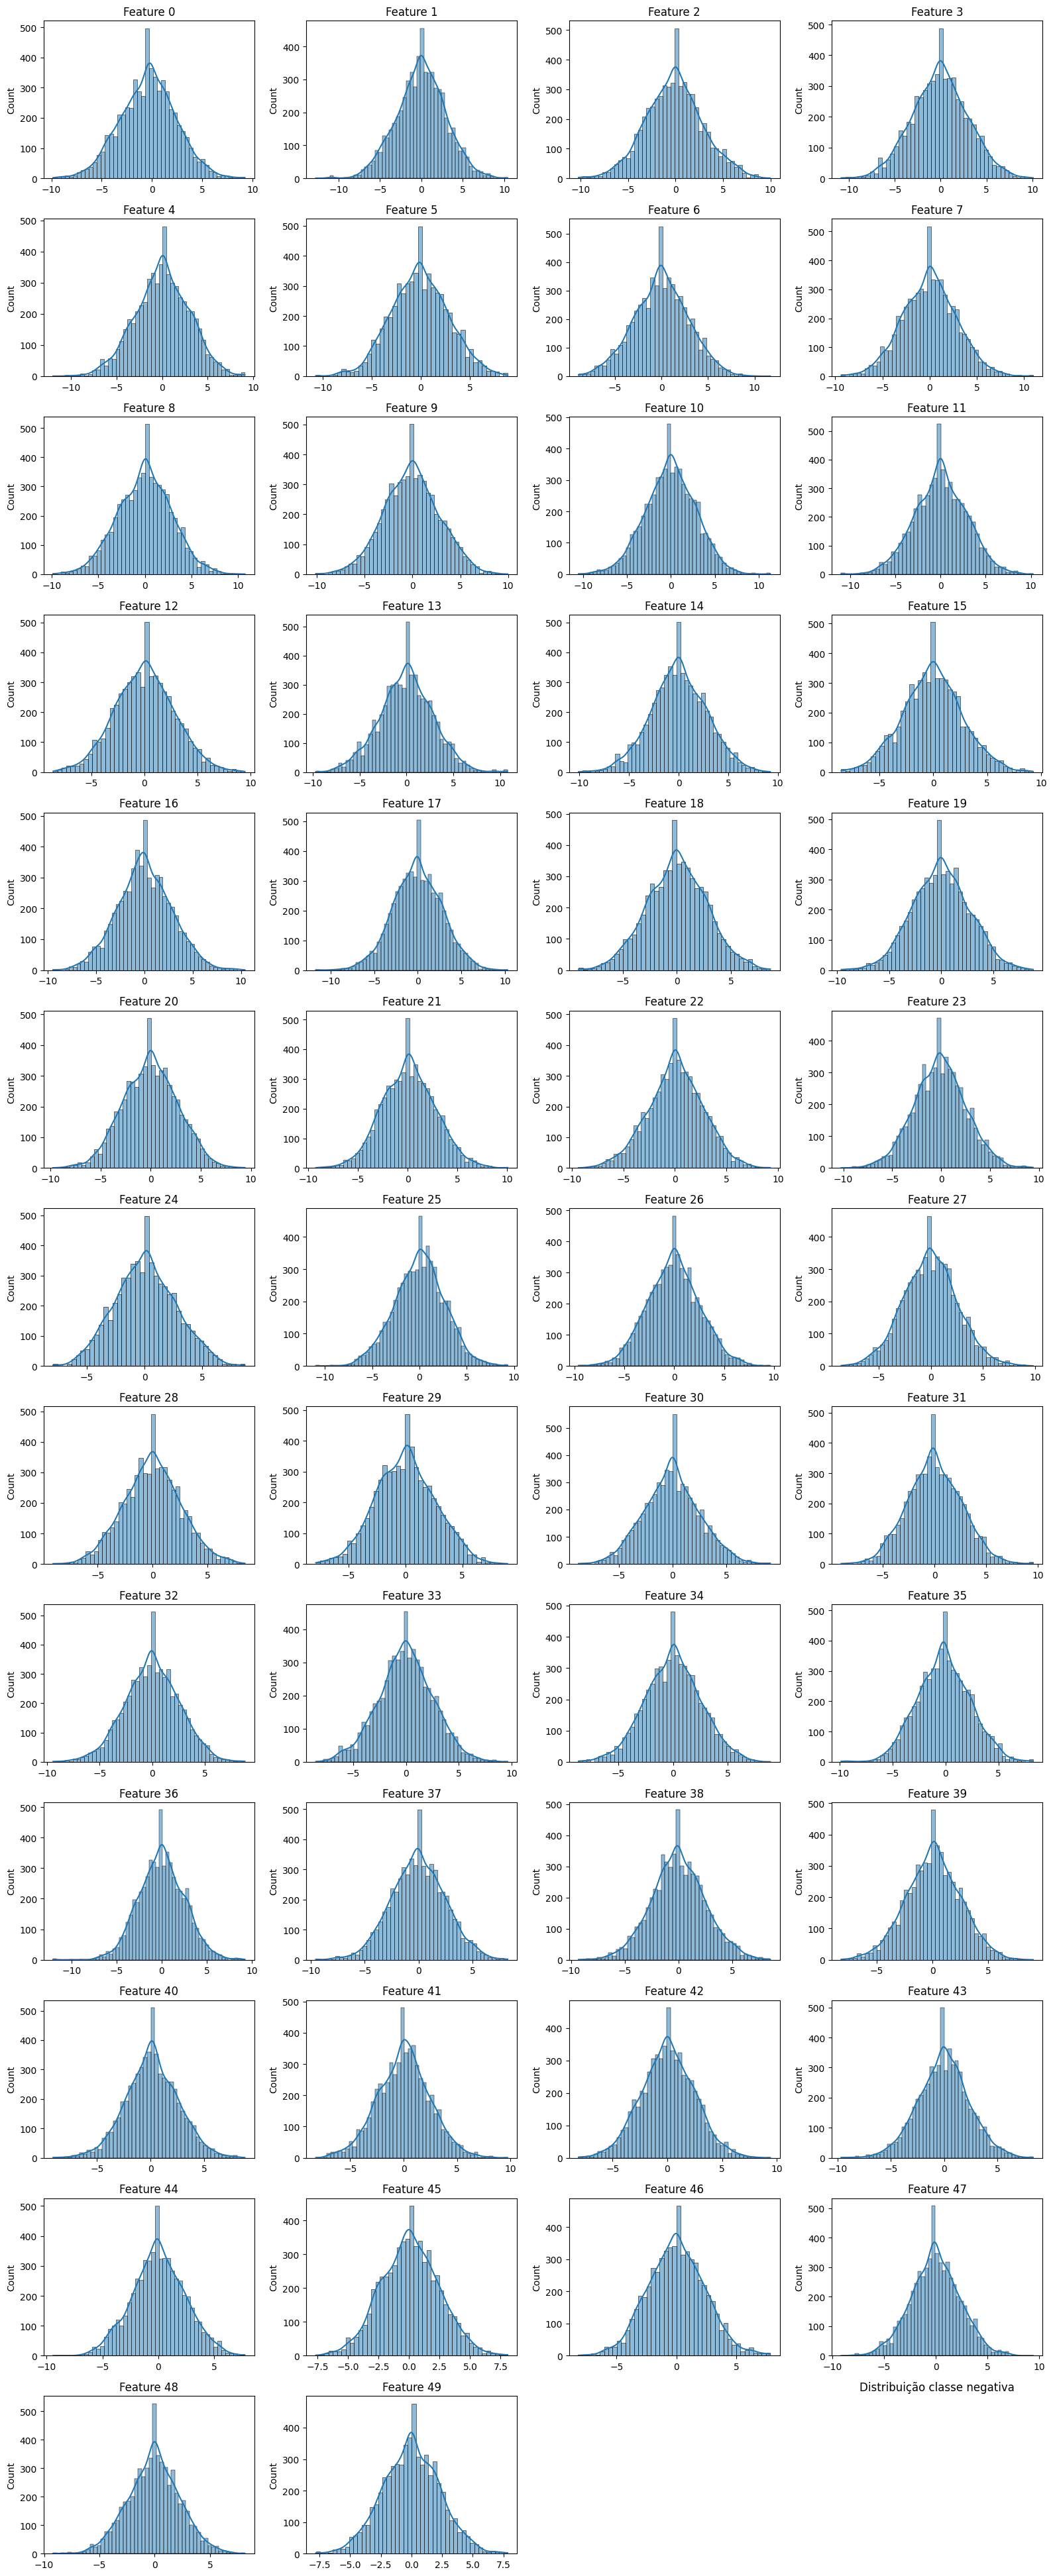

In [ ]:
df_0 = df[df['y'] == 0].drop(columns=['y'])
show_features_hist(np.array(df_0[cols[:50]]), title='Distribuição classe negativa')

Vemos que o PCA preservou a característica vista no início em que
a distribição das features na classe positiva possuem distribuição
aproximadamente normal, enquanto que na classe negativa a distribuição
é simétrica, mas mais afunilada

# Aplicando Modelos

Aqui faremos o treinamento dos modelos. Para modelos que exigem
validação cruzada, iremos tentar otimizar o F1 score, visto o
desbalanceamento das classes. Também utilizaremos a biblioteca imblearn
para amostrar dados da classe minoritária bara lidar com o desbalanceamento.

In [ ]:
def matprint(mat, fmt="g", round_dig = 0):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            if round_dig == 0:
                print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
            else:
                print(("{:"+str(col_maxes[i])+fmt+"}").format(round(y, round_dig)), end="  ")
        print("")

class ConfusionMatrixMetrics:
    def __init__(self, matrix):
        """
        Inicializa a classe com uma matriz de confusão 2x2.
        A matriz deve estar no formato:
        [[VN, FP],
         [FN, VP]]
        onde:
        - VP: Verdadeiros Positivos
        - FP: Falsos Positivos
        - FN: Falsos Negativos
        - VN: Verdadeiros Negativos
        """
        self.matrix = matrix

        self.VN = self.matrix[0][0]
        self.FP = self.matrix[0][1]
        self.FN = self.matrix[1][0]
        self.VP = self.matrix[1][1]

        self.N = self.matrix[0][0] + self.matrix[0][1]
        self.P = self.matrix[1][0] + self.matrix[1][1]

        self.Pop = self.N + self.P

    def prev(self):
        """Calcula a prevalência da classe positiva"""
        try:
            return (self.P)/(self.Pop)
        except ZeroDivisionError:
            return 0.0

    def acc(self):
        """Calcula a acurária"""
        try:
            return (self.VN + self.VP)/self.Pop
        except ZeroDivisionError:
            return 0.0

    def FPR(self):
        """Calcula a FPR"""
        try:
            return self.FP/self.N
        except ZeroDivisionError:
            return 0.0

    def TNR(self):
        """Calcula a TNR"""
        try:
            return self.VN/self.N
        except ZeroDivisionError:
            return 0.0

    def TPR(self):
        """Calcula a TPR"""
        try:
            return self.VP/self.P
        except ZeroDivisionError:
            return 0.0

    def FNR(self):
        """Calcula a FNR"""
        try:
            return self.FN/self.P
        except ZeroDivisionError:
            return 0.0

    def FOR(self):
        """Calcula a FOR"""
        try:
            return self.FN/(self.VN + self.FN)
        except ZeroDivisionError:
            return 0.0

    def PPV(self):
        """Calcula o PPV"""
        try:
            return self.VP/(self.FP + self.VP)
        except ZeroDivisionError:
            return 0.0

    def NPV(self):
        """Calcula a NPV"""
        try:
            return self.VN/(self.VN + self.FN)
        except ZeroDivisionError:
            return 0.0

    def FDR(self):
        """Calcula a FDR"""
        try:
            return self.FP/(self.FP + self.VP)
        except ZeroDivisionError:
            return 0.0

    def F1(self):
        """Calcula a F1"""
        try:
            return 2/(1/self.PPV() + 1/self.TPR())
        except ZeroDivisionError:
            return np.NaN

    def print(self):
        """Mostra todas as métricas calculadas acima"""
        print('Matriz de confusão:')
        matprint(self.matrix)

        print('\n')

        print('Prevalência:', np.round(self.prev(), 3))
        print('Acurácia:', np.round(self.acc(), 3))

        print('\n')

        print('Taxa de falsos positivos:', np.round(self.FPR(), 3))
        print('Taxa de verdadeiros negativos (Especificidade):',np.round(self.TNR(), 3))
        print('Taxa de verdadeiros positivos (Recall):', np.round(self.TPR(), 3))
        print('Taxa de falsos negativos:', np.round(self.FNR(), 3))

        print('\n')

        print('False omission rate:', np.round(self.FOR(), 3))
        print('Valor preditivo positivo (Precisão):', np.round(self.PPV(), 3))
        print('Valor preditivo negativo:', np.round(self.NPV(), 3))
        print('False discovery rate:', np.round(self.FDR(), 3))

        print('\n')

        print('F1 Score:', np.round(self.F1(), 3))
    ##############################################

In [ ]:
import datetime
import numpy as np

from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

from imblearn.over_sampling import SMOTE


# Essa classe foi escrita por mim para o projeto I.
# Eu usei um LLM aqui para reescrever a classe
# para o código ficar mais limpo e legível,
# diferente do que estava na primeira versão

class ModelTrainer:
    _base_model: BaseEstimator
    model_fit: GridSearchCV | Pipeline = None

    cv_timedelta: datetime.timedelta = None
    train_timedelta: datetime.timedelta = None

    cv: bool = False

    def __init__(self, base_model: BaseEstimator):
        self._base_model = base_model

    # ------------------------------------------------------------------ #
    # Utils internos
    # ------------------------------------------------------------------ #

    def __rename_paramkeys(self, param_grid: dict | None):
        """
        Renomeia as chaves do param_grid para uso dentro da Pipeline
        """
        if not param_grid:
            return None

        return {
            f"estimator__{key}": value
            for key, value in param_grid.items()
        }

    def __build_pipeline(self):
        return Pipeline(
            steps=[
                ('scaler', StandardScaler()),
                ('pca', PCA(n_components=200)),
                ('smote', SMOTE(random_state=42)),
                ('estimator', self._base_model)
            ]
        )

    # ------------------------------------------------------------------ #
    # Treinamento
    # ------------------------------------------------------------------ #

    def train(self, X, y, **kwargs):
        """
        Pipeline de treinamento:

        1 - Criação da pipeline
        2 - (Opcional) Validação cruzada
        3 - Registro de tempos
        """

        model_pipe = self.__build_pipeline()

        param_grid = kwargs.pop('param_grid', None)
        cv_folds  = kwargs.pop('cv', 5)

        if param_grid:
            self.cv = True
            self.model_fit = GridSearchCV(
                model_pipe,
                param_grid=self.__rename_paramkeys(param_grid),
                cv=cv_folds,
                scoring='f1',
                **kwargs
            )
        else:
            self.cv = False
            self.model_fit = model_pipe

        # ----------------- #
        # Execução
        # ----------------- #

        if self.cv:
            start = datetime.datetime.now()
            self.model_fit.fit(X, y)
            self.cv_timedelta = datetime.datetime.now() - start

            start = datetime.datetime.now()
            self.model_fit.best_estimator_.fit(X, y)
            self.train_timedelta = datetime.datetime.now() - start
        else:
            start = datetime.datetime.now()
            self.model_fit.fit(X, y)
            self.train_timedelta = datetime.datetime.now() - start


    # ------------------------------------------------------------------ #
    # Resumos
    # ------------------------------------------------------------------ #

    def gen_summary(self):
        if self.cv:
            print(f"Tempo de validação cruzada : {self.cv_timedelta}")
            print(f"Tempo de treinamento       : {self.train_timedelta}")
            print(f"Melhor estimador           : {self.model_fit.best_estimator_}")
        else:
            print(f"Tempo de treinamento       : {self.train_timedelta}")

    def summary_metrics(self, X, y):
            """
            Gera resumo de métricas usando ConfusionMatrixMetrics
            """

            # ---------------- Predição + tempo ---------------- #
            start = datetime.datetime.now()
            y_pred = self.model_fit.predict(X)
            pred_time = datetime.datetime.now() - start

            # ---------------- Confusion Matrix ---------------- #
            cm = confusion_matrix(y, y_pred)

            # Garantir formato:
            # [[VN, FP],
            #  [FN, VP]]
            matrix = np.array([
                [cm[0, 0], cm[0, 1]],
                [cm[1, 0], cm[1, 1]]
            ])

            metrics = ConfusionMatrixMetrics(matrix)

            # ---------------- Output ---------------- #
            metrics.print()
            print(f"\nTempo de predição: {pred_time}")

# ---------------------------------------------------------------------- #
# Função auxiliar (mantida no seu estilo)
# ---------------------------------------------------------------------- #

def run_test(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    **kwargs
):
    trainer = ModelTrainer(model)

    trainer.train(X_train, y_train, **kwargs)
    trainer.gen_summary()
    trainer.summary_metrics(X_test, y_test)

    return trainer.model_fit


In [ ]:
from sklearn.metrics import roc_curve, auc

# Essa função foi gerada por um LLM
def plot_roc(model, X, y, threshold=0.5, print_result=False):
    """
    Plota curva ROC para classificação binária
    """

    # ---------------- Scores ---------------- #
    start = datetime.datetime.now()

    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X)
    else:
        raise AttributeError("O modelo não fornece scores contínuos para ROC.")

    pred_time = datetime.datetime.now() - start

    # ---------------- ROC ---------------- #
    fpr, tpr, thresholds = roc_curve(y, y_score)
    roc_auc = auc(fpr, tpr)

    # ---------------- Plot ---------------- #
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], "--", label="Aleatório")

    y_pred =(y_score > threshold).astype(int)
    cm = ConfusionMatrixMetrics(confusion_matrix(y, y_pred))
    plt.plot(cm.FPR(), cm.TPR(), 'o', c='r', label='classificador')

    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("Curva ROC")
    plt.legend()
    plt.grid(True)

    plt.show()

    print(f"AUC: {roc_auc:.3f}")
    print(f"Tempo para gerar scores: {pred_time}")

    if print_result:
        cm.print()


In [ ]:
X_train = pd.DataFrame(pre_process(feat))
X_test = pd.DataFrame(pre_process(feat_test))
y_train = resp['Volcano?']
y_test = resp_test['Volcano?']

In [ ]:
# liberar memória
del feat
del feat_test

# Classificadores Gaussianos

Os classificadores gaussianos (Naive Bayes Gaussiano e Análise de Discriminante)
requerem que duas hipótese:

- Normalidade das features
- Independência

Dada a quantidade de features, é difícil constatar elas,
mas já vimos que uma amostra das features, na classe positiva, se aproximam
da normal, e na classe negativa, elas possuem ao menos
uma distribuição simétrica similar. A independência veremos na próxima seção

## LDA

A Análise de discriminante linear requer, além das hipóteses acima, que
a matriz de covariância das features dada a classe sejam iguais. Vamos
tentar confirmar isso de maneira indireta através da norma da diferença
das matrizes e também com uma comparação visual.

In [ ]:
forbenius = np.linalg.norm(X_train[resp['Volcano?'] == 1].cov() - X_train[resp['Volcano?'] == 0].cov())
rel_0 = forbenius / np.linalg.norm(np.array(X_train[resp['Volcano?'] == 1]))
rel_1 = forbenius / np.linalg.norm(np.array(X_train[resp['Volcano?'] == 0]))
print(f'Norma relativa classe positiva: {rel_1:.2f}')
print(f'Norma relativa classe negativa: {rel_0:.2f}')


v = np.linalg.norm(X_test[y_test == 0].cov()) / np.linalg.norm(X_test[y_test == 1].cov() )
print(f'Razão entre as normas: {v:.2f}')

Norma relativa classe positiva: 0.02
Norma relativa classe negativa: 0.04
Razão entre as normas: 0.81


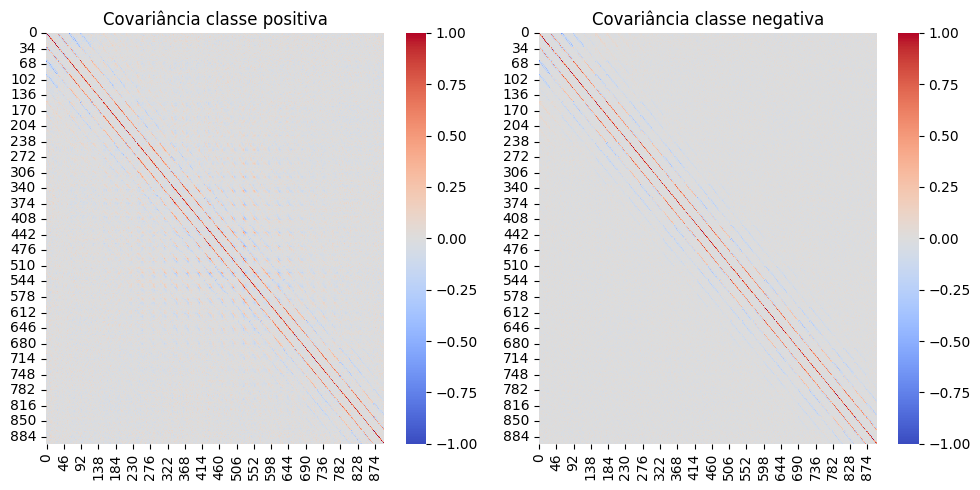

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(X_train[resp['Volcano?'] == 1].cov(), cmap='coolwarm', vmax=1, vmin=-1, ax=ax[0])
ax[0].set_title('Covariância classe positiva')
sns.heatmap(X_train[resp['Volcano?'] == 0].cov(), cmap='coolwarm', vmax=1, vmin=-1, ax=ax[1])
ax[1].set_title('Covariância classe negativa')
plt.tight_layout()

Podemos ver que a norma relativa da diferença entre as duas matrizez para
as classes poitivas e negativas foram, respectivamente, de 2% e 4%,
e a razão entre suas normas é relativamente próximo de 1. Pela inspeção visual, percebe-se
que as features dada a classe positiva estão mais um pouco correlacionadas do
que quando as observamos dada a classe negativas. Contudo, as diferenças são muito
sutis

Visto esses resultados e a grande dimensão dos dados, podemos considerar as matrizes de covariância suficientemente
próximas de forma a tornar razoável a hipótese de que elas são iguais.

Text(0.5, 1.0, 'Matriz de covariância dos dados')

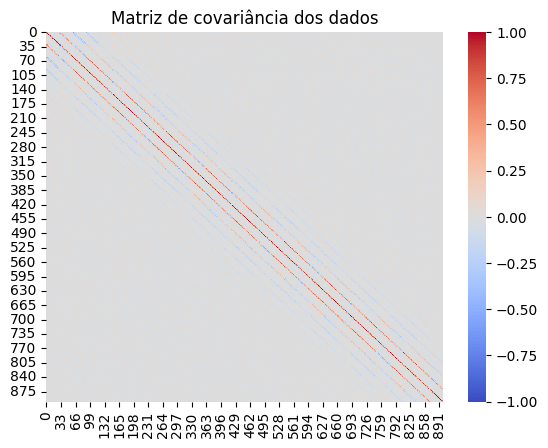

In [ ]:
sns.heatmap(X_train.cov(), cmap='coolwarm', vmax=1, vmin=-1)
plt.title('Matriz de covariância dos dados')

Na matriz de covariância completa, observa-se que alguns pixels que estão
mais próximos possuem covariância não nula, o que pode ser visto pelas
linhas vermelhas e azuis paralelas a diagonal principal. Porém, em boa
parte dos pares de features, essa covariância é perto de 0. Dessa forma,
considera-se que razoável que boa parte das features sejam independnetes entre
si.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = run_test(
    LDA(),
    X_train,
    y_train,
    X_test,
    y_test
)

Tempo de treinamento       : 0:00:03.488735
Matriz de confusão:
1980  320  
 119  315  


Prevalência: 0.159
Acurácia: 0.839


Taxa de falsos positivos: 0.139
Taxa de verdadeiros negativos (Especificidade): 0.861
Taxa de verdadeiros positivos (Recall): 0.726
Taxa de falsos negativos: 0.274


False omission rate: 0.057
Valor preditivo positivo (Precisão): 0.496
Valor preditivo negativo: 0.943
False discovery rate: 0.504


F1 Score: 0.589

Tempo de predição: 0:00:00.072645


Obteve-se um F1 score razoável para um modelo simples como o LDA (58%)
e uma taxa moderada de falsos negativos, no caso 27%.

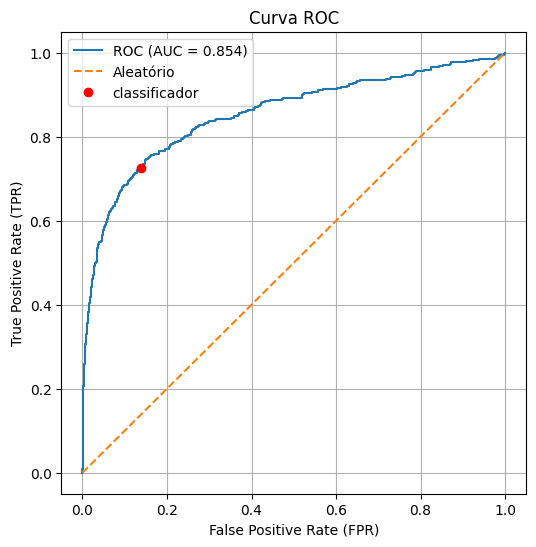

AUC: 0.854
Tempo para gerar scores: 0:00:00.043122


In [ ]:
plot_roc(lda, X_test, y_test)

Pelo formato da curva ROC, o classificador a priori já parece ter
sido bem próximo do melhor calssificador de LDA.

## QDA

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
qda = run_test(
    QDA(),
    X_train,
    y_train,
    X_test,
    y_test
)

Tempo de treinamento       : 0:00:03.434475
Matriz de confusão:
2224  76  
 407  27  


Prevalência: 0.159
Acurácia: 0.823


Taxa de falsos positivos: 0.033
Taxa de verdadeiros negativos (Especificidade): 0.967
Taxa de verdadeiros positivos (Recall): 0.062
Taxa de falsos negativos: 0.938


False omission rate: 0.155
Valor preditivo positivo (Precisão): 0.262
Valor preditivo negativo: 0.845
False discovery rate: 0.738


F1 Score: 0.101

Tempo de predição: 0:00:00.051901


Obteve desempenho pior do que o LDA. Um hipótese é de que sua
flexibilidade pode ter levado a se viciar mais no teste, além de ter
dado mais importância as variações nas matrizes de covariâncias das classes

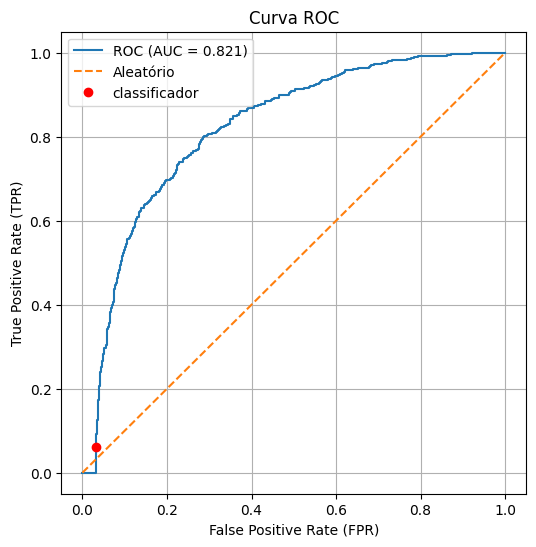

AUC: 0.821
Tempo para gerar scores: 0:00:00.060236


In [ ]:
plot_roc(qda, X_test, y_test)

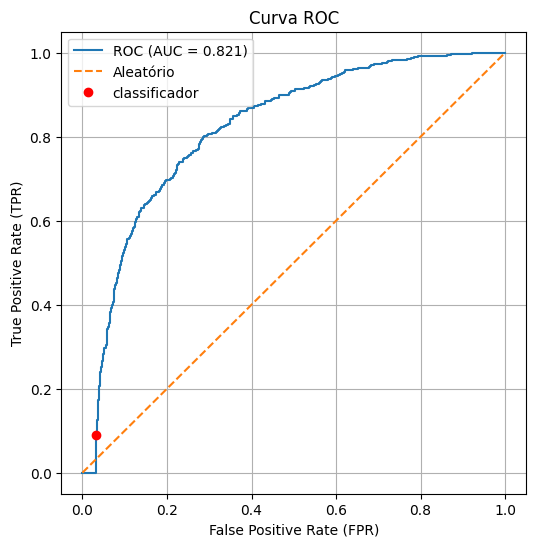

AUC: 0.821
Tempo para gerar scores: 0:00:00.068759


In [ ]:
plot_roc(qda, X_test, y_test, 0.05)

Mesmo dando um peso bem alto para falsos negativos, o modelo
não varia muito

## Naive Bayes

Vimos que uma amostra das features, dada a classe positiva, parecem ser normais,
mas o mesmo não pode ser dito das negativas. Logo, iremos usar o Naive Bayes gaussiano,
mas sem esprar bons resultados

In [ ]:
from sklearn.naive_bayes import GaussianNB

GNB = run_test(
    GaussianNB(),
    X_train,
    y_train,
    X_test,
    y_test
)

Tempo de treinamento       : 0:00:02.873329
Matriz de confusão:
2204   96  
 330  104  


Prevalência: 0.159
Acurácia: 0.844


Taxa de falsos positivos: 0.042
Taxa de verdadeiros negativos (Especificidade): 0.958
Taxa de verdadeiros positivos (Recall): 0.24
Taxa de falsos negativos: 0.76


False omission rate: 0.13
Valor preditivo positivo (Precisão): 0.52
Valor preditivo negativo: 0.87
False discovery rate: 0.48


F1 Score: 0.328

Tempo de predição: 0:00:00.036047


Obtemos um F1 score mais baixo do que no LDA, mas considarevelmente mais
alto do que o QDA. Ele também erra um pouco mais que a metade das vezes.

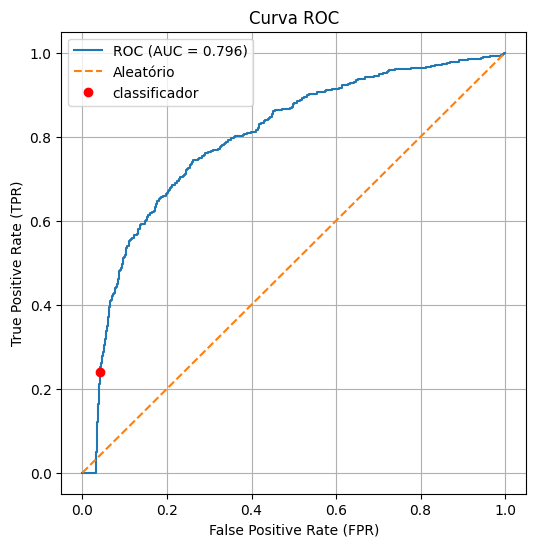

AUC: 0.796
Tempo para gerar scores: 0:00:00.053823


In [ ]:
plot_roc(GNB, X_test, y_test)

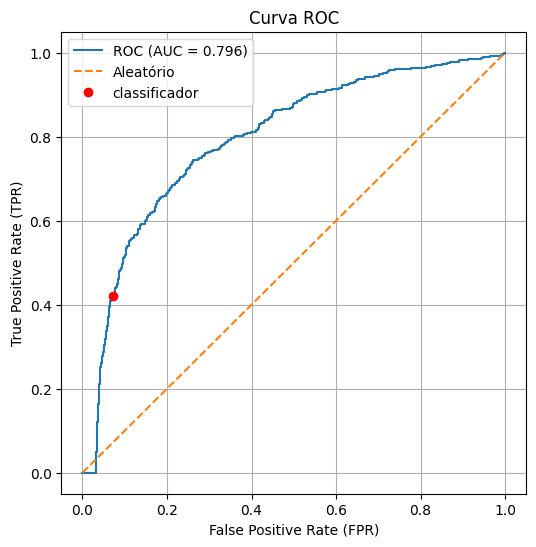

AUC: 0.796
Tempo para gerar scores: 0:00:00.088467
Matriz de confusão:
2136  164  
 251  183  


Prevalência: 0.159
Acurácia: 0.848


Taxa de falsos positivos: 0.071
Taxa de verdadeiros negativos (Especificidade): 0.929
Taxa de verdadeiros positivos (Recall): 0.422
Taxa de falsos negativos: 0.578


False omission rate: 0.105
Valor preditivo positivo (Precisão): 0.527
Valor preditivo negativo: 0.895
False discovery rate: 0.473


F1 Score: 0.469


In [ ]:
plot_roc(GNB, X_test, y_test, 1/9, print_result=True)

O classificador, como o QDA, tem dificuldade em classificar coreetamente elementos
da classe negativa.

## SVM

In [ ]:
from sklearn.svm import SVC

param_grid_SVM = {
    'kernel': ['rbf', 'linear'],
    'C': [0.001, 0.01, 1]

}

SVM = run_test(
    SVC(max_iter=4000, class_weight='balanced'),
    X_train,
    y_train,
    X_test,
    y_test,
    param_grid=param_grid_SVM,
    n_jobs = 10
)

/home/john/academics/apmaq/Projetos/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/john/academics/apmaq/Projetos/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/john/academics/apmaq/Projetos/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/john/academics/apmaq/Projetos/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/john/a

Tempo de validação cruzada : 0:02:33.764878
Tempo de treinamento       : 0:00:08.257382
Melhor estimador           : Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=200)),
                ('smote', SMOTE(random_state=42)),
                ('estimator',
                 SVC(C=1, class_weight='balanced', max_iter=4000))])
Matriz de confusão:
2273   27  
 175  259  


Prevalência: 0.159
Acurácia: 0.926


Taxa de falsos positivos: 0.012
Taxa de verdadeiros negativos (Especificidade): 0.988
Taxa de verdadeiros positivos (Recall): 0.597
Taxa de falsos negativos: 0.403


False omission rate: 0.071
Valor preditivo positivo (Precisão): 0.906
Valor preditivo negativo: 0.929
False discovery rate: 0.094


F1 Score: 0.719

Tempo de predição: 0:00:01.354537


Obtemos um F1 score razoavelmente alto para este modelo,
com uma taxa de falsos negativos mais baixa do que os modelos
iniciais de Análise de Discriminante, e consequentemente um recall mais alto.

In [ ]:
SVM.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=200)),
                ('smote', SMOTE(random_state=42)),
                ('estimator',
                 SVC(C=1, class_weight='balanced', max_iter=4000))])

O melhor kernel foi o RBF, o que é esperado, já
que até então não temos nenhuma evidência de que os
dados sejam linearmente separáveis.

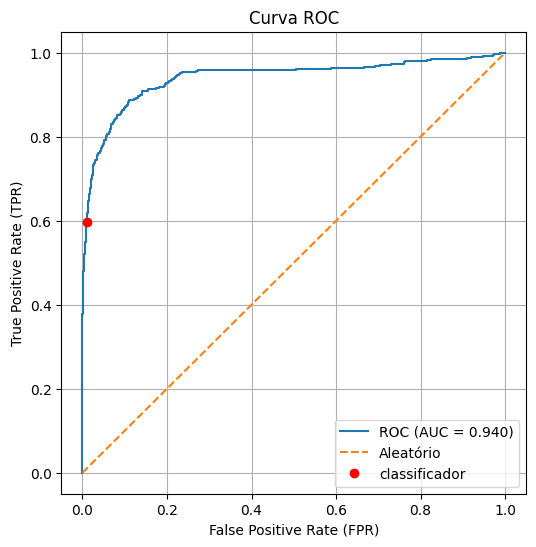

AUC: 0.940
Tempo para gerar scores: 0:00:01.759176


In [ ]:
plot_roc(SVM, X_test, y_test, 0)

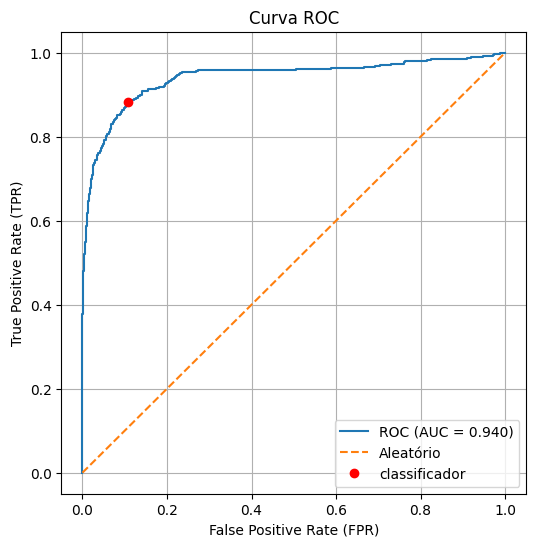

AUC: 0.940
Tempo para gerar scores: 0:00:02.135741
Matriz de confusão:
2050  250  
  51  383  


Prevalência: 0.159
Acurácia: 0.89


Taxa de falsos positivos: 0.109
Taxa de verdadeiros negativos (Especificidade): 0.891
Taxa de verdadeiros positivos (Recall): 0.882
Taxa de falsos negativos: 0.118


False omission rate: 0.024
Valor preditivo positivo (Precisão): 0.605
Valor preditivo negativo: 0.976
False discovery rate: 0.395


F1 Score: 0.718


In [ ]:
plot_roc(SVM, X_test, y_test, -0.6, print_result=True)

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

param_grid_KNN = {
    'n_neighbors': range(3, 12, 2),
    'p': range(1, 5),
    'weights': ['uniform', 'distance']
}

KNN = run_test(
    KNeighborsClassifier(),
    X_train,
    y_train,
    X_test,
    y_test,
    param_grid=param_grid_KNN,
    n_jobs = 10
)

Tempo de validação cruzada : 0:16:04.997766
Tempo de treinamento       : 0:00:03.776583
Melhor estimador           : Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=200)),
                ('smote', SMOTE(random_state=42)),
                ('estimator',
                 KNeighborsClassifier(n_neighbors=3, p=4, weights='distance'))])
Matriz de confusão:
2234   66  
 288  146  


Prevalência: 0.159
Acurácia: 0.871


Taxa de falsos positivos: 0.029
Taxa de verdadeiros negativos (Especificidade): 0.971
Taxa de verdadeiros positivos (Recall): 0.336
Taxa de falsos negativos: 0.664


False omission rate: 0.114
Valor preditivo positivo (Precisão): 0.689
Valor preditivo negativo: 0.886
False discovery rate: 0.311


F1 Score: 0.452

Tempo de predição: 0:00:24.151323


In [ ]:
KNN.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=200)),
                ('smote', SMOTE(random_state=42)),
                ('estimator',
                 KNeighborsClassifier(n_neighbors=3, p=4, weights='distance'))])

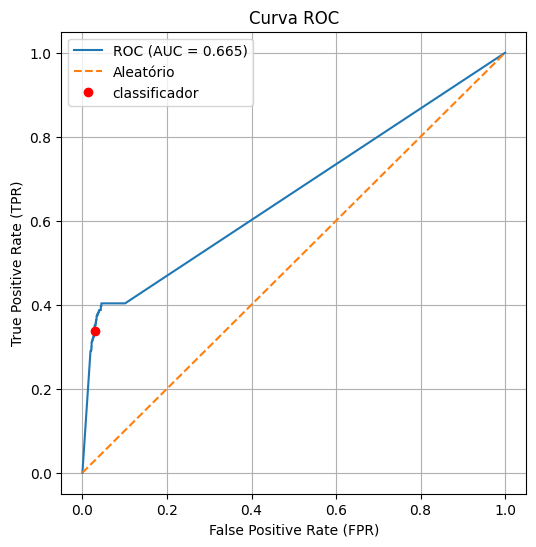

AUC: 0.665
Tempo para gerar scores: 0:00:19.554592


In [ ]:
plot_roc(KNN, X_test, y_test)

## Árvore de Decisão

In [ ]:
from sklearn.tree import DecisionTreeClassifier

param_grid_DT = {
    'criterion': ['gini', 'entropy'],
    'ccp_alpha': [0.0001, 0.001, 0.1, 0.5]
}

DT = run_test(
    DecisionTreeClassifier(min_samples_leaf=5),
    X_train,
    y_train,
    X_test,
    y_test,
    param_grid=param_grid_DT,
    n_jobs = 10
)

Tempo de validação cruzada : 0:00:41.914998
Tempo de treinamento       : 0:00:06.717243
Melhor estimador           : Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=200)),
                ('smote', SMOTE(random_state=42)),
                ('estimator',
                 DecisionTreeClassifier(ccp_alpha=0.001, min_samples_leaf=5))])
Matriz de confusão:
1885  415  
 192  242  


Prevalência: 0.159
Acurácia: 0.778


Taxa de falsos positivos: 0.18
Taxa de verdadeiros negativos (Especificidade): 0.82
Taxa de verdadeiros positivos (Recall): 0.558
Taxa de falsos negativos: 0.442


False omission rate: 0.092
Valor preditivo positivo (Precisão): 0.368
Valor preditivo negativo: 0.908
False discovery rate: 0.632


F1 Score: 0.444

Tempo de predição: 0:00:00.025437


In [ ]:
DT.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=200)),
                ('smote', SMOTE(random_state=42)),
                ('estimator',
                 DecisionTreeClassifier(ccp_alpha=0.001, min_samples_leaf=5))])

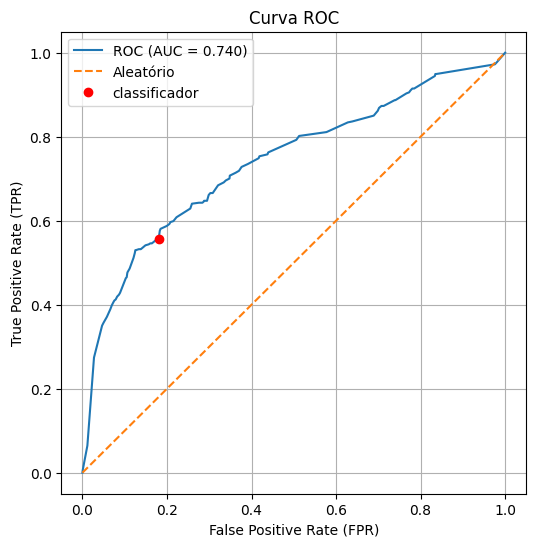

AUC: 0.740
Tempo para gerar scores: 0:00:00.038362


In [ ]:
plot_roc(DT, X_test, y_test)

## Bagging e Floresta Aleatória

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

param_grid_BAG = {
    'n_estimators': [50, 100]
}

BG = run_test(
    BaggingClassifier(DecisionTreeClassifier(min_samples_leaf=5, criterion='gini', ccp_alpha=0.001)),
    X_train,
    y_train,
    X_test,
    y_test,
    param_grid=param_grid_BAG,
    n_jobs=10
)

Tempo de validação cruzada : 0:28:34.612771
Tempo de treinamento       : 0:14:06.234583
Melhor estimador           : Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=200)),
                ('smote', SMOTE(random_state=42)),
                ('estimator',
                 BaggingClassifier(estimator=DecisionTreeClassifier(ccp_alpha=0.001,
                                                                    min_samples_leaf=5),
                                   n_estimators=100))])
Matriz de confusão:
2153  147  
 195  239  


Prevalência: 0.159
Acurácia: 0.875


Taxa de falsos positivos: 0.064
Taxa de verdadeiros negativos (Especificidade): 0.936
Taxa de verdadeiros positivos (Recall): 0.551
Taxa de falsos negativos: 0.449


False omission rate: 0.083
Valor preditivo positivo (Precisão): 0.619
Valor preditivo negativo: 0.917
False discovery rate: 0.381


F1 Score: 0.583

Tempo de predição: 0:00:00.535532


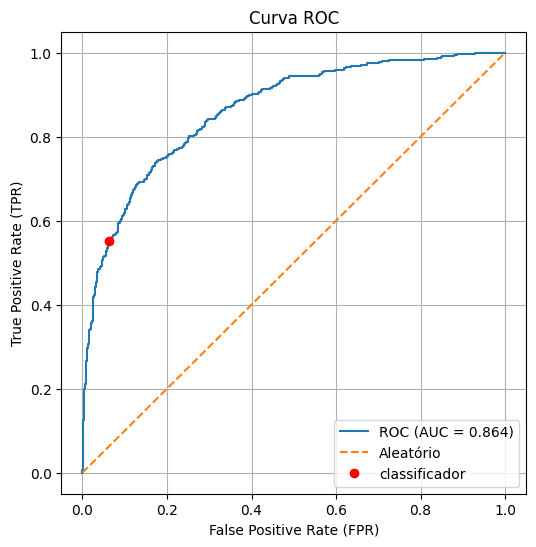

AUC: 0.864
Tempo para gerar scores: 0:00:00.490382


In [ ]:
plot_roc(BG, X_test, y_test)

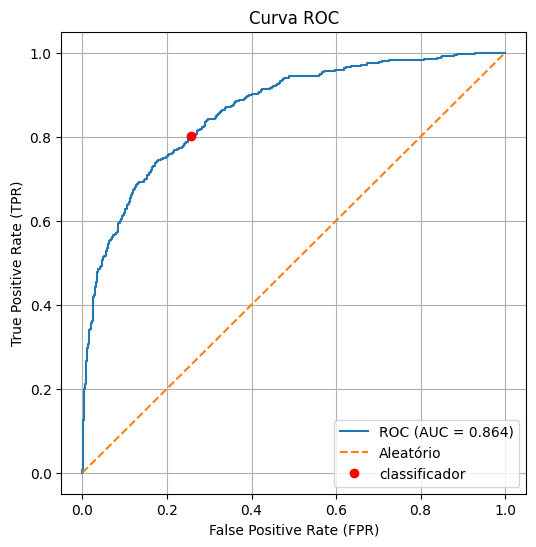

AUC: 0.864
Tempo para gerar scores: 0:00:00.873647
Matriz de confusão:
1708  592  
  86  348  


Prevalência: 0.159
Acurácia: 0.752


Taxa de falsos positivos: 0.257
Taxa de verdadeiros negativos (Especificidade): 0.743
Taxa de verdadeiros positivos (Recall): 0.802
Taxa de falsos negativos: 0.198


False omission rate: 0.048
Valor preditivo positivo (Precisão): 0.37
Valor preditivo negativo: 0.952
False discovery rate: 0.63


F1 Score: 0.507


In [ ]:
plot_roc(BG, X_test, y_test, 0.3, print_result=True)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_grid_RF = {
    'ccp_alpha': [0.0001, 0.001, 0.01, 0.1],
    'n_estimators': [50, 100]
}

RF = run_test(
    RandomForestClassifier(min_samples_leaf=5, max_features='sqrt'),
    X_train,
    y_train,
    X_test,
    y_test,
    param_grid=param_grid_RF,
    n_jobs=10
)

Tempo de validação cruzada : 0:01:45.600063
Tempo de treinamento       : 0:00:21.366431
Melhor estimador           : Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=200)),
                ('smote', SMOTE(random_state=42)),
                ('estimator',
                 RandomForestClassifier(ccp_alpha=0.001, min_samples_leaf=5))])
Matriz de confusão:
2228   72  
 206  228  


Prevalência: 0.159
Acurácia: 0.898


Taxa de falsos positivos: 0.031
Taxa de verdadeiros negativos (Especificidade): 0.969
Taxa de verdadeiros positivos (Recall): 0.525
Taxa de falsos negativos: 0.475


False omission rate: 0.085
Valor preditivo positivo (Precisão): 0.76
Valor preditivo negativo: 0.915
False discovery rate: 0.24


F1 Score: 0.621

Tempo de predição: 0:00:00.059497


In [ ]:
RF

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=200)),
                                       ('smote', SMOTE(random_state=42)),
                                       ('estimator',
                                        RandomForestClassifier(min_samples_leaf=5))]),
             n_jobs=10,
             param_grid={'estimator__ccp_alpha': [0.0001, 0.001, 0.01, 0.1],
                         'estimator__n_estimators': [50, 100]},
             scoring='f1')

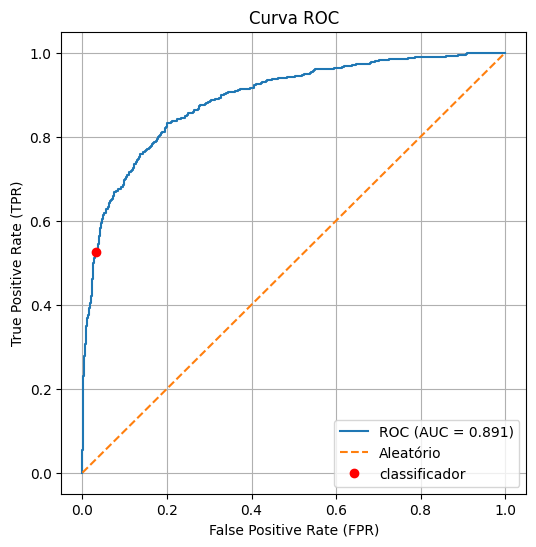

AUC: 0.891
Tempo para gerar scores: 0:00:00.082034


In [ ]:
plot_roc(RF, X_test, y_test)

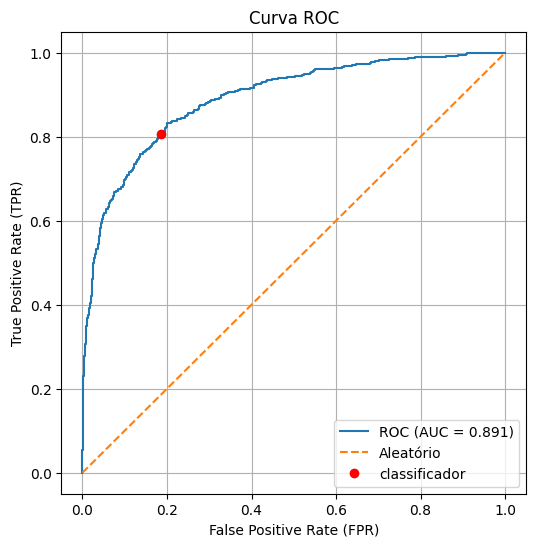

AUC: 0.891
Tempo para gerar scores: 0:00:00.161610
Matriz de confusão:
1871  429  
  84  350  


Prevalência: 0.159
Acurácia: 0.812


Taxa de falsos positivos: 0.187
Taxa de verdadeiros negativos (Especificidade): 0.813
Taxa de verdadeiros positivos (Recall): 0.806
Taxa de falsos negativos: 0.194


False omission rate: 0.043
Valor preditivo positivo (Precisão): 0.449
Valor preditivo negativo: 0.957
False discovery rate: 0.551


F1 Score: 0.577


In [ ]:
plot_roc(RF, X_test, y_test, 0.38, print_result=True)

# Discussão dos Resultados

## Calssificadores Gaussianos

### LDA

- Acurácia: 0.839
- Taxa de falsos positivos: 0.139
- Taxa de verdadeiros negativos (Especificidade): 0.861
- Taxa de verdadeiros positivos (Recall): 0.726
- Taxa de falsos negativos: 0.274
- Valor preditivo positivo (Precisão): 0.496
- Valor preditivo negativo: 0.943
- F1 Score: 0.589

O algoritmo performou melhor do que esperávamos, obtendo
F1 score de 58%, acomapnhado de 27% de taxa de erro das
classes positivas. Camo já discutimos, parece razoável algumas
das hipóteses feitas para aplicação do LDA, o que deve explicar seu desempenho aqui

Abaixo, plota-se um histograma dos valores dos discriminantes distinguindo-se
as classes.

Text(0.5, 1.0, 'Separação de Classes no Espaço LDA')

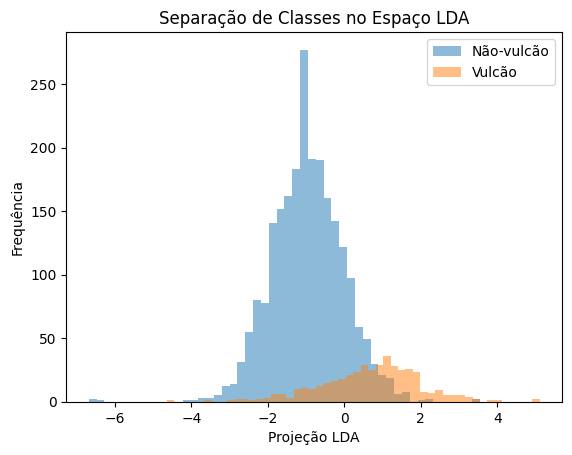

In [ ]:
# Projeta dados no eixo LDA
X_lda = lda.transform(X_test)  # Shape: (n_samples, 1)

# Histograma por classe
plt.hist(X_lda[y_test==0], bins=50, alpha=0.5, label='Não-vulcão')
plt.hist(X_lda[y_test==1], bins=50, alpha=0.5, label='Vulcão')
plt.xlabel('Projeção LDA')
plt.ylabel('Frequência')
plt.legend()
plt.title('Separação de Classes no Espaço LDA')

Pelo histograma, é possível que o LDA consegue separar um certo número das
observações da classe positiva, o que explica o resultado obtidos do
classificador a priori.

### QDA

- Acurácia: 0.823
- Taxa de falsos positivos: 0.033
- Taxa de verdadeiros negativos (Especificidade): 0.967
- Taxa de verdadeiros positivos (Recall): 0.062
- Taxa de falsos negativos: 0.938
- Valor preditivo positivo (Precisão): 0.262
- Valor preditivo negativo: 0.845
- F1 Score: 0.101

Vistos a discussão do LDA, e os resultados obtidos pelo QDA, podemos
afirmar que o segundo modelo performou pior do que o primeiro. Como havíamos
observado mais atrás, é razoável considerar as hipóteses de normalidade (ao menos para
classe positiva), independência (por causa das covariâncias majoriatariamente próximas
de zero), e das matrizes de covariância serem muito semelhantes. Desse modo, o uso
do QDA nessas condições, ainda mais por ser um modelo mais flexível, pode gerar
overfitting, pois ele dá maior importância as diferenças sútis que comentamos antes
na matriz de covariância de dados. Vamos observar seu comportamento no conjunto de treino


In [ ]:
y_pred = qda.predict(X_train)
cm = confusion_matrix(y_train, y_pred)
ConfusionMatrixMetrics(cm).print()

Matriz de confusão:
5841  159  
 260  740  


Prevalência: 0.143
Acurácia: 0.94


Taxa de falsos positivos: 0.026
Taxa de verdadeiros negativos (Especificidade): 0.974
Taxa de verdadeiros positivos (Recall): 0.74
Taxa de falsos negativos: 0.26


False omission rate: 0.043
Valor preditivo positivo (Precisão): 0.823
Valor preditivo negativo: 0.957
False discovery rate: 0.177


F1 Score: 0.779


Como hipotetizado, a performance no QDA no treino foi consideravelmente alta, com
boas métricas e taxas de verdadeiros e
falsos positivos. Dessa maneira, podemos afirmar que o QDA performou pior do que
o LDA porque ele sofreu overfitting.

### Naive Bayes

- Acurácia: 0.844
- Taxa de falsos positivos: 0.042
- Taxa de verdadeiros negativos (Especificidade): 0.958
- Taxa de verdadeiros positivos (Recall): 0.24
- Taxa de falsos negativos: 0.76
- Valor preditivo positivo (Precisão): 0.52
- Valor preditivo negativo: 0.87
- F1 Score: 0.328

O classificador de Naive Bayes gaussiano, assim como o QDA,
não obteve resultados muito bons no conjunto de teste. Uma hipótese para
isso é que, as fórmulas de discriminante, apesar de serem derivadas da
suposição de normalidade das features, não usam a função de densidade
de probabilidade diretamente na função de discriminante. Dessa forma,
o Naive Bayes é mais dependente da normalidade dos dados para conseguir performar
bem, o que não podemos garantir nessa situação. Mesmo ajustando o thershhold,
o classificador a posteriori não obteve resultados tão melhores.

## SVM

A Máquina de Vetores Suporte apresentou resultados consideravelmente bons
em relação aos outros modelos. O classificador a prori obteve bons resultados
de teste, contudo ainda com uma taxa moderada de falsos negativos.

- Acurácia: 0.926
- Taxa de falsos positivos: 0.012
- Taxa de verdadeiros negativos (Especificidade): 0.988
- Taxa de verdadeiros positivos (Recall): 0.597
- Taxa de falsos negativos: 0.403
- Valor preditivo positivo (Precisão): 0.906
- F1 Score: 0.719

No entanto, ao ajustarmos as margens,
obtemos um bom classificador

- Acurácia: 0.89
- Taxa de falsos positivos: 0.109
- Taxa de verdadeiros negativos (Especificidade): 0.891
- Taxa de verdadeiros positivos (Recall): 0.882
- Taxa de falsos negativos: 0.118
- Valor preditivo positivo (Precisão): 0.605
- Valor preditivo negativo: 0.976
- F1 Score: 0.718

Conseguimos reduzir bastante a taxa de falsos negativos,
que foi para somente 11% das observações, ou seja, o modelo
está acertando um menos de 1 imagem com vulcão a cada 10.
O mesmo vale para taxa de falsos positivos, em que a taxa
é praticamente a mesma que a anterior. Observemos também
que o F1 score se manteve o mesmo, o que indica que, mesmo ao
ajustar as margens, manteve-se o equilíbrio entre recall e
precisão, que também pode ser visto pelo formato íngrime da
curva ROC.

## KNN

- Acurácia: 0.871
- Taxa de falsos positivos: 0.029
- Taxa de verdadeiros negativos (Especificidade): 0.971
- Taxa de verdadeiros positivos (Recall): 0.336
- Taxa de falsos negativos: 0.664
- Valor preditivo positivo (Precisão): 0.689
- Valor preditivo negativo: 0.886
- F1 Score: 0.452

No KNN, o número de vizinhos obtidos por validação cruzada foi 3, ou seja, o modelo
obtido é um modelo complexo e que não conseguiu aprender as características das features.
Parte do problema podemos, talvez, atribuir à maldição da dimensionalidade, visto
que estamos lidando com um número razoavelmente alto de features para o KNN (200 features).

## Bagging

O Bagging a priori obteve muitos dos mesmos problemas:
classifica quase metade das observações da classe positiva
de forma incorreta.

- Acurácia: 0.875
- Taxa de falsos positivos: 0.064
- Taxa de verdadeiros negativos (Especificidade): 0.936
- Taxa de verdadeiros positivos (Recall): 0.551
- Taxa de falsos negativos: 0.449
- Valor preditivo positivo (Precisão): 0.619
- F1 Score: 0.583

Ajustando o threshold, consegue-se obter o classificador com
os seguintes resultados:

- Acurácia: 0.752
- Taxa de falsos positivos: 0.257
- Taxa de verdadeiros negativos (Especificidade): 0.743
- Taxa de verdadeiros positivos (Recall): 0.802
- Taxa de falsos negativos: 0.198
- Valor preditivo positivo (Precisão): 0.37
- F1 Score: 0.507

Consegue-se reduzir um mas que pela metade a taxa de falsos negativos,
mas ao custo de uma piora significativa em quase em todas as outras métricas.


## Floresta Aleatória

Obteve-se as seguintes métricas para a Floresta Aleatória
a priori:

- Acurácia: 0.898
- Taxa de falsos positivos: 0.031
- Taxa de verdadeiros negativos (Especificidade): 0.969
- Taxa de verdadeiros positivos (Recall): 0.525
- Taxa de falsos negativos: 0.475
- Valor preditivo positivo (Precisão): 0.76
- Valor preditivo negativo: 0.915
- F1 Score: 0.621

Obtemos, por validação cruazada, um floresta com 100 estmadores.
Ajustando o threshold para classificar as classes, obtemos os seguintes
resultados.

- Acurácia: 0.812
- Taxa de falsos positivos: 0.187
- Taxa de verdadeiros negativos (Especificidade): 0.813
- Taxa de verdadeiros positivos (Recall): 0.806
- Taxa de falsos negativos: 0.194
- Valor preditivo positivo (Precisão): 0.449
- F1 Score: 0.577

Comparando com o Bagging, a floresta aleatória conseguiu
performar um pouco melhor em algumas métricas, provavelmente
pelo fato de criar estimadores menos correlacionados.

# Conclusão

O processamento de imagens é uma tarefa difícil,
pois a variações entre os pixels a depender dasa classes nas
quais trabalha-se podem incrivelmente sutis e difíceis de conseguir
expressar suas informações latentes. O processamento realizado aqui
foi obtido por uma sucessão de tentativa e erro até conseguir resultados
razoáveis para a performance dos modelos. Outros recortes foram feitos
para as imagens, como 50x50 e 10x10, mas todos com problemas: 50x50 gerava features
demais, quase impossível de trabalhar no hardware disponível, enquanto que 10x10 havia
muito pouca informação, e os modelos degeneravam-se em classificadores que apenas sorteavam
uma moeda para deicidir a classe. O recorte de 30x30 acabou balanceando essas questões.
Também tentou-se outros filtros e transformações, como o Canny e o Sobel, usados para
detecção de bordas, o que poderia ser útil para detectar bordas de vulcões. Porém, como dito,
a variação entre os pixel são muito sutis, e as transformações aplicadas não conseguiam diferenciar
as features suficientemente para dar informações que distinguissem em classes.

Quanto ao treinamento dos modelos, boa parte deles se comportaram de maneira semelhante,
ainda mais após ajuste do threshold para controlar o peso dado a cada classe. Nesse contexto, o modelo
que sem dúvidas obteve melhor performance foi o SVM. Provavelmente, ao transformar o espaço das features para
dimensão maior, a separação das classes pode ter se tornado mais fácil, o que se manifestou nos resultados.
A curva ROC do modelo também mostro que ajustes para aumentar a taxa de verdadeiros positivos praticamente
não altera a taxa de falsos positivos. Aqui
vale também uma menção honrosa ao LDA: um dos modelos mais simples obteve resultados tão bons quantos modelos
altamente flexíveis como Árvore de Decisão e Floresta Aleatória.